# Forecasting Injections With Prophet
- __My last model used Exponential Smoothing to forecast the number of injections per day for the medical clinic that I work at, now I am going to use Facebook's Prophet library to forecast and compare the models__

In [458]:
import os
import numpy.random as nr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
import seaborn as sns
import missingno as msno
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 5000)
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import plotly_express as px


import pickle
from flask import Flask, request, jsonify, render_template

#lines below let allow multiple results from a line of code to be shown e.g. df.head() + df.columns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#displaying numbers instead of scientific notation
pd.options.display.float_format = '{:.2f}'.format

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

#evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

#prophet forecasting
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

In [234]:
#import data from EWMA without outliers
df = pd.read_csv('injection_forecast_without_outliers.csv')

## Data Transformation
- __Prophet requires that the columns in the data be 1) a date or timestamp with the column label of 'ds' and 2) the actual data for the time series labeled as 'y'__
- __Without renaming these columns the model will not run__
- __Additionally, the data should only have 2 columns, you may add in extra regressors as well, but in a basic model there should only be the two__

In [3]:
df.head()

,date,number_of_injections,trend
0,2012-09-04,152,154.35
1,2012-09-05,149,153.53
2,2012-09-06,150,152.72
3,2012-09-07,201,151.89
4,2012-09-10,144,151.06


In [5]:
#rename columns and drop trend
df = df[['date', 'number_of_injections']]
df.columns = ['ds', 'y']

In [42]:
#make sure that the columns are correct
df.head()

,ds,y
0,2012-09-04,152
1,2012-09-05,149
2,2012-09-06,150
3,2012-09-07,201
4,2012-09-10,144


## Creating A Baseline Forecast
- __I am going to be intantiating a model and creating a baseline forecast for the data, with a period of 5 days into the future__
- __Forecasts come with a prediction as well as a 95% confidence interval for the prediction__

In [54]:
#instantiate the model
m = Prophet(changepoint_prior_scale=0.01).fit(df)

#creating future dataframe to predict with, adding 5 days to the future dataframe 
future = m.make_future_dataframe(periods=7)

#cutting out weekends from future data, since we dont have data for weekends
future = future[future['ds'].dt.dayofweek < 5]

#making forecast
forecast = m.predict(future)

#looking at forecast, it appears as though we have CIs of about + or - 28
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1763,2020-01-03,248.99,222.41,276.49
1764,2020-01-06,202.73,177.09,230.54
1765,2020-01-07,196.86,170.54,225.37
1766,2020-01-08,203.59,175.83,229.65
1767,2020-01-09,209.66,183.71,237.51


## Visualize Predictions With Previous Data
- __Here I want to see if the predictions are acting as an extension of the previous data's trend components to see if the model seems to be predicting reasonable values__
- __Predicted values are the final piece of the line where there are no residual dots__

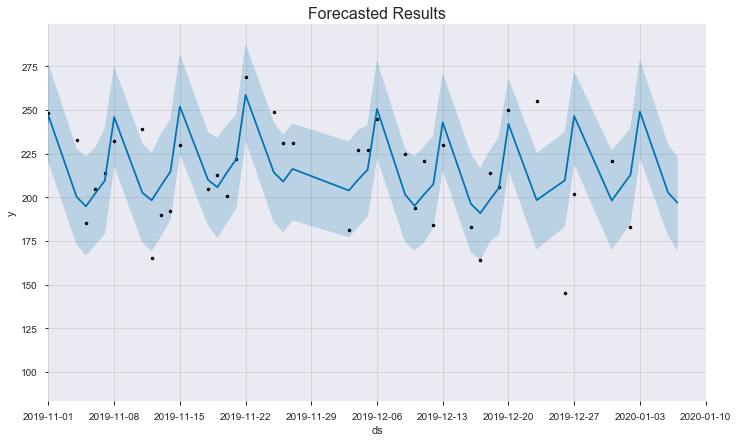

In [50]:
#change datetime to object for plotting
forecast['ds'] = forecast['ds'].astype('object')

#since conversion to object didn't work, I had to use this code to ignore the datetime aspect: 
# https://stackoverflow.com/questions/43206554/typeerror-float-argument-must-be-a-string-or-a-number-not-period
pd.plotting.register_matplotlib_converters()

#visualize forecast
forecast_plot = m.plot(forecast)
plt.xlim('2019-11-01', '2020-01-10')
plt.title('Forecasted Results', fontsize = 16);

## Trend and Seasonality
- __Prophet comes with a great built-in ETS decomposition function that plots the 'components' of the data__
- __Components are broken down into overall trend, weekly trend, and yearly trend__
    - Here the plots are suggesting a clear linear trend overall, with a weekly trend growing steadily and peaking on Friday
    - Lastly, and perhaps most interesting to me, is the seasonal look, which indicates several peaks throughout the year. Primarily, the injections peak in the spring, with two more peaks in June and August, followed by a peak in the early fall, followed by one final peak in the latter part of November, culminating in a sharp decline until March

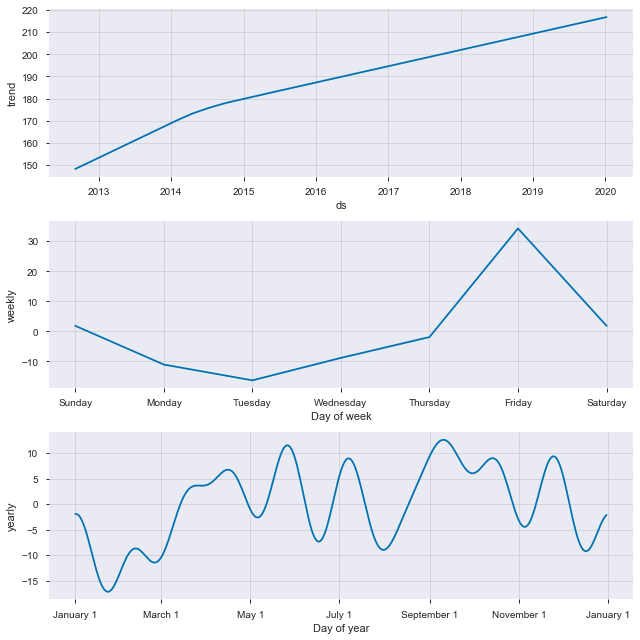

In [40]:
#plot components
components_plot = m.plot_components(forecast)

## Check RMSE for Out-Of-Sample 5-Day Forecast
- checking the predictions for the 5 days above vs. the data from the actual injection counts for those days
- well...13.9 is really not too shabby for such a basic model!

In [77]:
check = pd.DataFrame({'predictions':[248.99, 202.73, 197, 204, 210], 'actual': [252, 239, 190, 184, 213]})

print(f' RMSE of Prophet 5 Day Forecast: {sum(np.abs(check["predictions"] - check["actual"]))/5}')

 RMSE of Prophet 5 Day Forecast: 13.856


## Saving Model
- exporting the model into a file to save for later use using "pickle" package
- pickling a model allows you to save models for use later, which helps in case your kernel dies or jupyter lab times out

In [80]:
# save the model to disk
filename = 'stage_one_prophet_model.sav'
pickle.dump(m, open(filename, 'wb'))

In [81]:
# load the model from disk 
model = pickle.load(open(filename, 'rb'))

## Basic Out-of-the-Box Model
- Forecast For Next Five Days

In [417]:
df = pd.read_csv('Prophet Forecast Data.csv', names = ['ds', 'y', 'location'])
df = df[['ds', 'y']]
df.sort_values('ds', inplace = True)
df.shape

(1862, 2)

In [418]:
def iqr_outlier_removal(df, column):
    
    #using the lower and upper quantiles to find outliers
    q1 = pd.DataFrame(df[column]).quantile(0.25)[0]
    q3 = pd.DataFrame(df[column]).quantile(0.75)[0]
    iqr = q3 - q1 #Interquartile range

    fence_low = q1 - (1.5*iqr)
    fence_high = q3 + (1.5*iqr)

    #I am going to remove all outliers included outside of lower and upper fences
    outliers = []
    outliers.append(df[df[column] > fence_high][column])
    outliers.append(df[df[column] < fence_low][column])
    outliers = pd.concat(outliers)
    outliers = [outlier for outlier in outliers]

    #drop outliers from data
    for x in df[column]:
        if x in outliers:
            df = df[df[column] != x]
    return df

df = iqr_outlier_removal(df, 'y')

df.shape

(1779, 2)

In [419]:
#create training and test set, with df being the training set
test = df.tail()
df = df.drop(df.tail().index)

In [420]:
#instantiate the model
m = Prophet().fit(df)

#creating future dataframe to predict with, adding 5 days to the future dataframe 
future = m.make_future_dataframe(periods=7)

#cutting out weekends from future data, since we dont have data for weekends
future = future[future['ds'].dt.dayofweek < 5]

#making forecast
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [339]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1774,2020-01-13,222.40,173.13,227.36,222.40,222.40,-22.56,-22.56,-22.56,-13.33,-13.33,-13.33,-9.23,-9.23,-9.23,0.00,0.00,0.00,199.83
1775,2020-01-14,222.43,166.25,219.59,222.43,222.43,-29.26,-29.26,-29.26,-18.90,-18.90,-18.90,-10.36,-10.36,-10.36,0.00,0.00,0.00,193.17
1776,2020-01-15,222.45,171.27,225.08,222.45,222.45,-22.62,-22.62,-22.62,-11.15,-11.15,-11.15,-11.46,-11.46,-11.46,0.00,0.00,0.00,199.84
1777,2020-01-16,222.48,178.61,231.59,222.48,222.48,-16.73,-16.73,-16.73,-4.21,-4.21,-4.21,-12.53,-12.53,-12.53,0.00,0.00,0.00,205.75
1778,2020-01-17,222.51,215.12,268.98,222.51,222.51,18.74,18.74,18.74,32.26,32.26,32.26,-13.52,-13.52,-13.52,0.00,0.00,0.00,241.25


In [348]:
scoring_df = pd.DataFrame({'predictions': forecast.iloc[:, -1].tail().values, 'actual': test.iloc[:, -1].values})
print(f"Number of Injections Off On Average: {np.mean(np.abs(scoring_df['predictions'] - scoring_df['actual']))}")

Number of Injections Off On Average: 19.932499946573436


# Hyperparameter Tuning
- __Start with growth and changepoint_prior_scale, move this up to a value between 1-30 as suggested by this blog post: https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3__
- __Subsequent tunings are going to be based on this same reference__

### Growth - Linear or Logistic?
- This hyperparameter can be tuned by simply looking at the growth trend of the data, if it is linear or curved. As we saw in the decomposition plot earlier, the data is growing on a fairly linear trend with no saturation in sight, so I will choose linear. For current reference, here is the data:

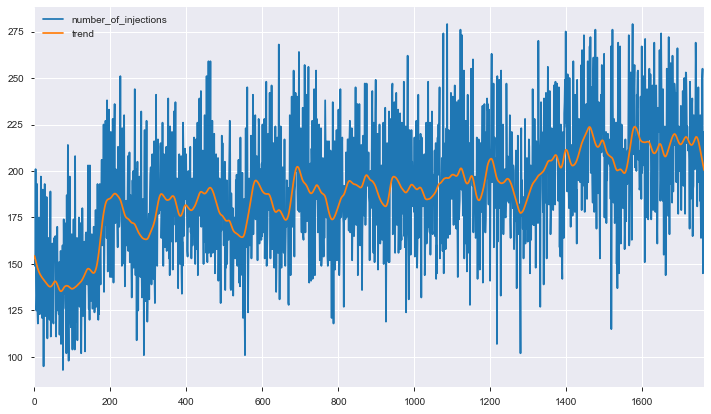

In [235]:
df.plot(figsize = (12, 7));

## Grid Search for Changepoint Optimal Value
- Changepoints are places in the data where the trend ubruptly shifts, such as an increase or decrease in value
- Prophet determines these points on its own unless you supply a list of specific changepoints, but this is not usually advisable unless you know exactly when the data shifts relative to the mean
- changepoint_prior_scale is a hyperparameter that allows prophet to essentially dictate how much the model should factor in these changepoints for its predictions, with a higher value perhaps being more flexible
- I am goig to be searching over a value from 0, 30 to see which of these scale values reduces error the most

In [349]:
%%time

errors = []

changepoints = list(range(1, 30, 1))

for changepoint in changepoints:
    
    #instantiate the model
    m = Prophet(changepoint_prior_scale=changepoint, daily_seasonality = True, growth = 'linear').fit(df)

    #making forecast
    forecast = m.predict(future)
    
    #getting predictions for last 5 days and combining them with the check data 
    predictions = pd.DataFrame({'predictions': [x for x in forecast.iloc[:, -1].tail().values], 'actual': [x for x in scoring_df['actual']]})
    
    #appending the errors to analyze
    errors.append(np.mean(np.abs((predictions['predictions'] - predictions['actual']))))

Wall time: 5min 10s


### Looks like 5 is the best value for the changepoint judging by this list
- __This value can be computed for the best possible average error based on all data up to a certain point on a weekly basis, that way if it changes then the new model can receive this value even if it is different week-to-week__

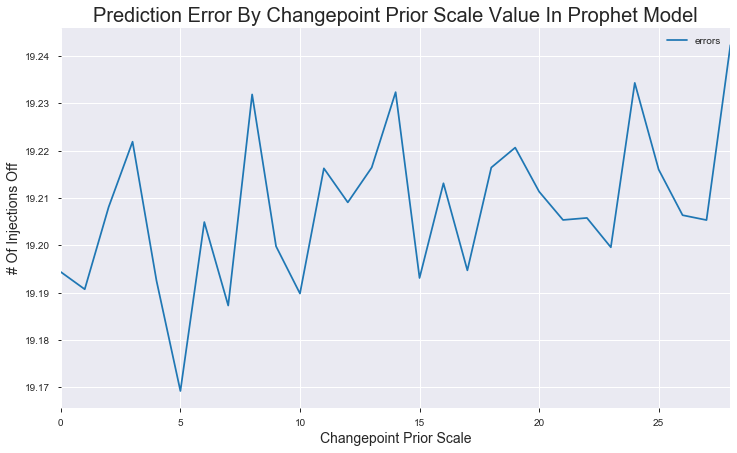

In [350]:
pd.DataFrame({'errors': [x for x in errors]}).plot(figsize = (12, 7))
plt.title('Prediction Error By Changepoint Prior Scale Value In Prophet Model', fontsize = 20)
plt.xlabel('Changepoint Prior Scale', fontsize = 14)
plt.ylabel('# Of Injections Off', fontsize = 14);

In [351]:
#find value of lowest RMSE for changepoint
pd.DataFrame({'errors': [x for x in errors]}).idxmin()

errors    5
dtype: int64

## Holidays Tuning
- I am going to use Pandas' built-in holiday calendar for providing a list of holidays to the model, they will simply be federal holidays that are also observed by the company. Prophet has a built in holidays calendar as well, but the model performed better with the Pandas calendar for some reason.
- I will then use the holidays_prior_scale to determine which value is best, this operates similarly to changepoint_prior_scale which we tuned above
- __Holidays must be provided for all historical data in addition to as far out as you want to predict with columns (holiday, ds)__

In [354]:
#import holidays and create df
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = pd.DataFrame({'holiday': 'holiday', 'ds': cal.holidays(start='2012-01-01', end='2020-12-31').to_pydatetime()})

In [365]:
#instantiate the model
m = Prophet(changepoint_prior_scale=19, daily_seasonality = True, growth = 'linear', holidays = holidays).fit(df)

#making forecast
forecast = m.predict(future)
    
#getting predictions for last 5 days
predictions = pd.DataFrame({'predictions': [x for x in forecast.iloc[:, -1].tail().values]})
    
#getting the actual values from the check created earlier
actual = pd.DataFrame({'actual': [x for x in check['actual']]})
    
#appending the errors to analyze
np.mean(np.abs((predictions['predictions'] - actual['actual'])))

19.276181857965838

## Additive or Multiplicative?
- This parameter is confusing for this particular data set, I am simply going to be using both and seeing which is better (since additive is the default option, I will simply look at multiplicative and compare to the previous error)
- __It appears as though our model is performing better with a multiplicative seasonality mode__

In [366]:
#instantiate the model
m = Prophet(changepoint_prior_scale=19, daily_seasonality = True, growth = 'linear', holidays = holidays, seasonality_mode = 'multiplicative').fit(df)

#making forecast
forecast = m.predict(future)
    
#getting predictions for last 5 days
predictions = pd.DataFrame({'predictions': [x for x in forecast.iloc[:, -1].tail().values]})
    
#getting the actual values from the check created earlier
actual = pd.DataFrame({'actual': [x for x in check['actual']]})
    
#appending the errors to analyze
np.mean(np.abs((predictions['predictions'] - actual['actual'])))

17.87964505005697

## Seasonality Prior Scale Tuning
- This parameter is similar to the last prior scale values, deciding how the model should fit with seasonality in the data

Wall time: 5min 17s


Text(0, 0.5, '# Of Injections Off')

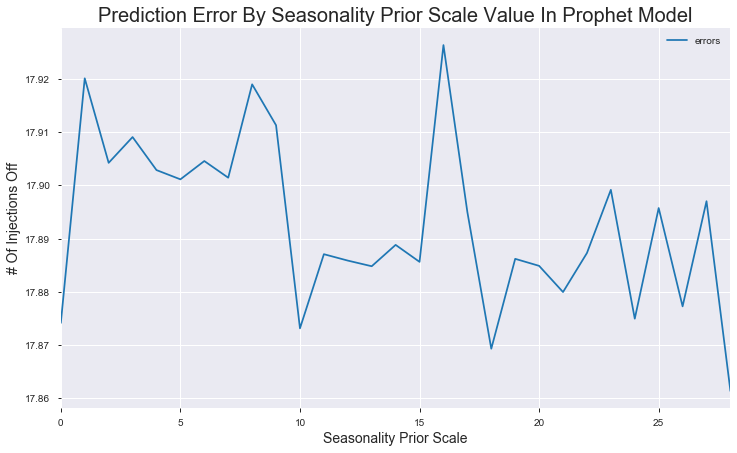

In [369]:
%%time

errors = []

seasonalities = list(range(1, 30, 1))

for seasonality in seasonalities:
    
    #instantiate the model
    m = Prophet(changepoint_prior_scale=changepoint, daily_seasonality = True, growth = 'linear', holidays = holidays, seasonality_mode = 'multiplicative',
               seasonality_prior_scale = seasonality).fit(df)

    #making forecast
    forecast = m.predict(future)
    
    #getting predictions for last 5 days
    predictions = pd.DataFrame({'predictions': [x for x in forecast.iloc[:, -1].tail().values]})
    
    #getting the actual values from the check created earlier
    actual = pd.DataFrame({'actual': [x for x in check['actual']]})
    
    #appending the errors to analyze
    errors.append(np.mean(np.abs((predictions['predictions'] - actual['actual']))))
    
#plot the errors
pd.DataFrame({'errors': [x for x in errors]}).plot(figsize = (12, 7))
plt.title('Prediction Error By Seasonality Prior Scale Value In Prophet Model', fontsize = 20)
plt.xlabel('Seasonality Prior Scale', fontsize = 14)
plt.ylabel('# Of Injections Off', fontsize = 14);

### 28 is the number that has the least error, albeit a small improvement

In [370]:
#find value of lowest RMSE for changepoint
pd.DataFrame({'errors': [x for x in errors]}).idxmin()

errors    28
dtype: int64

## Custom Seasonalities

In [421]:
#instantiate the most current model
# m = Prophet(changepoint_prior_scale=changepoint, daily_seasonality = False, weekly_seasonality = False, yearly_seasonality = False,
#             growth = 'linear', holidays = holidays, seasonality_mode = 'multiplicative',
#              seasonality_prior_scale = 28).add_seasonality(name = 'daily', period = 1, 
#             fourier_order = 15).add_seasonality(name = 'weekly', period = 7, fourier_order = 3).add_seasonality(name = 'monthly', 
#              period = 30.5, fourier_order = 12).add_seasonality(name = 'yearly', period = 365.25, fourier_order = 10).fit(df)

m = Prophet(changepoint_prior_scale=5, daily_seasonality = True, weekly_seasonality = True, yearly_seasonality = True,
            growth = 'linear', holidays = holidays, seasonality_mode = 'multiplicative',
             seasonality_prior_scale = 28).fit(df)

#creating future dataframe to predict with, adding 5 days to the future dataframe 
future = m.make_future_dataframe(periods=7)

#cutting out weekends from future data, since we dont have data for weekends
future = future[future['ds'].dt.dayofweek < 5]

#making forecast
forecast = m.predict(future)

In [423]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,holiday,holiday_lower,holiday_upper,holidays,holidays_lower,holidays_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
1774,2020-01-13,63.85,169.05,219.16,63.85,63.85,2.25,2.25,2.25,0.00,0.00,0.00,0.00,0.00,0.00,2.05,2.05,2.05,-0.06,-0.06,-0.06,-0.14,-0.14,-0.14,0.00,0.00,0.00,194.52
1775,2020-01-14,63.85,160.76,214.42,63.85,63.85,2.25,2.25,2.25,0.00,0.00,0.00,0.00,0.00,0.00,1.93,1.93,1.93,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,0.00,0.00,0.00,186.80
1776,2020-01-15,63.85,166.43,221.06,63.85,63.85,2.25,2.25,2.25,0.00,0.00,0.00,0.00,0.00,0.00,2.03,2.03,2.03,-0.04,-0.04,-0.04,-0.18,-0.18,-0.18,0.00,0.00,0.00,193.76
1777,2020-01-16,63.85,173.92,225.81,63.85,63.85,2.25,2.25,2.25,0.00,0.00,0.00,0.00,0.00,0.00,2.14,2.14,2.14,0.09,0.09,0.09,-0.20,-0.20,-0.20,0.00,0.00,0.00,200.53
1778,2020-01-17,63.86,213.05,266.29,63.86,63.86,2.25,2.25,2.25,0.00,0.00,0.00,0.00,0.00,0.00,2.77,2.77,2.77,0.74,0.74,0.74,-0.22,-0.22,-0.22,0.00,0.00,0.00,240.64


In [424]:
np.mean(np.abs(check['actual'] - forecast.tail().iloc[:, -1].values))

17.888359144433583

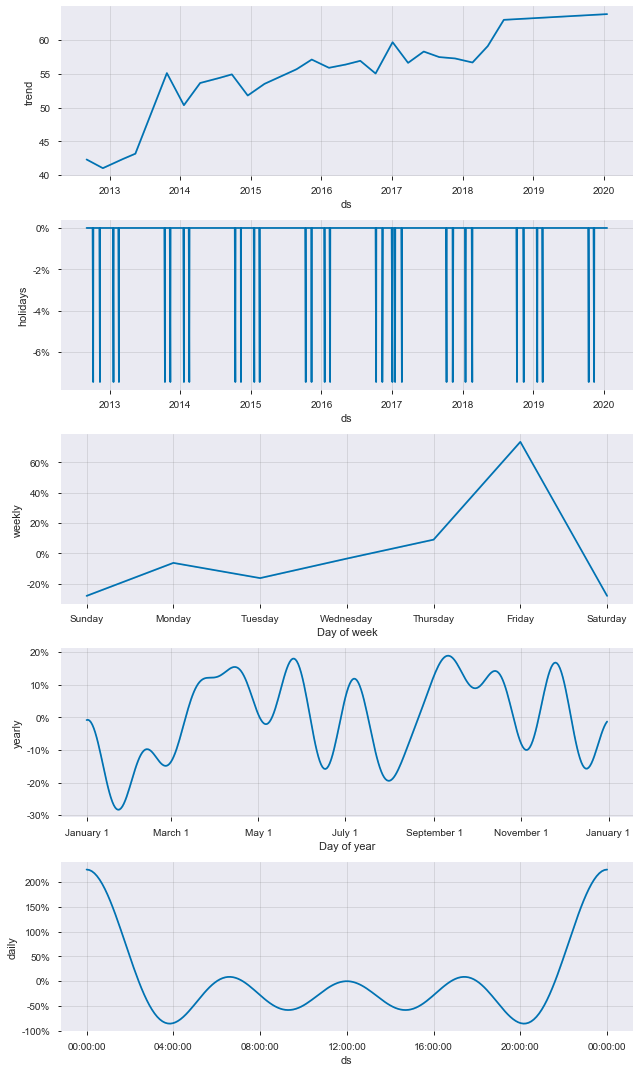

In [430]:
#have to use this code for the plot to render
pd.plotting.register_matplotlib_converters()
components = m.plot_components(forecast)

# Deploy Model Using Flask

## Dump Model
- __I am going to pickle the model to use with the Flask API__

In [406]:
# save the model to disk
filename = 'final_prophet_model.sav'
pickle.dump(m, open(filename, 'wb'))

In [437]:
model = pickle.load(open('final_prophet_model.sav','rb'))

## Flask Testing

- a response code of 200 means the app is working

In [501]:
import json
import requests

# local url
url = 'http://127.0.0.1:5000' # change to your url

# sample data
data = {'ds':'2020-02-04'}
data = json.dumps(data)

send_request = requests.post(url, data)
print(send_request)

<Response [200]>


In [502]:
#send a request to the api and get predictions back
print(send_request.json())

{'results': {'results': 186}}
